# Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

from khan_helpers import Experiment
from khan_helpers.constants import (
    CORRECT_ANSWER_COLOR, 
    FIG_DIR, 
    INCORRECT_ANSWER_COLOR
)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define some helper functions

In [2]:
def bootstrap_ci(M, ci=95, n_boots=1000, random_state=None):
    """
    Estimate a confidence interval for a given set of observations, or
    for each row of a 2D array.    
    """
    np.random.seed(random_state)
    M = np.atleast_2d(np.asarray(M))
    rand_ixs = np.random.randint(0, M.shape[1], size=(*M.shape, n_boots))
    boot_means = np.take_along_axis(M[:, np.newaxis], rand_ixs, axis=2).mean(axis=1)
    ci_low = np.percentile(boot_means, (100 - ci) / 2, axis=1)
    ci_high = np.percentile(boot_means, (ci + 100) / 2, axis=1)
    return [ci_low.item(), ci_high.item()]

# Compute proportion correct as a function of distance from a reference question

# <span style="color:red">TODO: exclude question 38 (index 37) from analysis? No non-zero weights</span>

In [3]:
exp = Experiment()

In [4]:
dist_bins = np.linspace(0, 2, 21)

datalist = []

for quiz in range(1, 4):
    for p in exp.participants:
        subid = p.subID
        # data for questions from given quiz
        quiz_data = p.get_data(quiz=quiz-1)
        # accuracy for each question on the quiz
        quiz_accuracies = quiz_data['accuracy']
        # simple proportion correct for the quiz
        quiz_prop_correct = quiz_accuracies.sum() / len(quiz_accuracies)
        # topic vectors for questions from the quiz
        quiz_questions_vecs = exp.question_vectors[quiz_data['qID'] - 1]
        # (correlation) distance matrix for questions on the quiz  
        quiz_questions_dists = cdist(quiz_questions_vecs, quiz_questions_vecs, 'correlation')
        # fix some floating point errors in cdist -- diag should be all 0's
        np.fill_diagonal(quiz_questions_dists, 0)

        # loop over questions on the quiz
        for question_ix in range(len(quiz_questions_dists)):
            qid = quiz_data['qID'].iloc[question_ix]
            # accuracy for given question
            question_accuracy = quiz_accuracies.iloc[question_ix]
            # (correlation) distance between given question and all 
            # questions on the quiz (including itself)
            question_dists = quiz_questions_dists[question_ix]

            # loop over bins (max distances within which to consider questions)
            for max_dist in dist_bins:
                # accuracy on questions within max_dist of reference question
                acc_within_dist = quiz_accuracies[question_dists <= max_dist]
                # number of questions within max_dist of reference question
                n_within_dist = len(acc_within_dist)
                if n_within_dist == 0:
                    raise RuntimeError

                datalist.append({
                    'quiz': quiz,
                    'participant': subid,
                    'raw_prop_correct': quiz_prop_correct,
                    'reference_question': qid,
                    'accuracy': question_accuracy,
                    'max_dist': max_dist,
                    'n_within_dist': n_within_dist,
                    'prop_correct': acc_within_dist.sum() / n_within_dist
                })

df = pd.DataFrame(datalist)
df

,quiz,participant,raw_prop_correct,reference_question,accuracy,max_dist,n_within_dist,prop_correct
0,1,P1,0.538462,13,1,0.0,1,1.000000
1,1,P1,0.538462,13,1,0.1,1,1.000000
2,1,P1,0.538462,13,1,0.2,1,1.000000
3,1,P1,0.538462,13,1,0.3,1,1.000000
4,1,P1,0.538462,13,1,0.4,2,0.500000
...,...,...,...,...,...,...,...,...
40945,3,P50,0.692308,20,1,1.6,13,0.692308
40946,3,P50,0.692308,20,1,1.7,13,0.692308
40947,3,P50,0.692308,20,1,1.8,13,0.692308
40948,3,P50,0.692308,20,1,1.9,13,0.692308


# Find distance past which topic-space distance provides no greater predictive value than simple proportion correct

In [71]:
# average over quiz questions within participants
grouped_df = (df
              .groupby(['quiz', 'participant', 'accuracy', 'max_dist'], as_index=False)
              .mean()
              .drop(columns=['reference_question', 'n_within_dist']))

# group data for across-participants calculations
grouper = grouped_df.groupby(['quiz', 'accuracy', 'max_dist'])

# across-participants average by-distance p(correct) & raw p(correct) 
# for each quiz/accuracy/max_dist combination
prop_correct_means = (grouper[['prop_correct', 'raw_prop_correct']]
                      .mean()
                      .reset_index(drop=True))

# confidence intervals for by-distance p(correct) & raw p(correct)
df_agg_ci = (grouper[['prop_correct', 'raw_prop_correct']]
             .agg(bootstrap_ci)
             .reset_index())
ci_cols = pd.DataFrame(df_agg_ci['prop_correct'].tolist(), 
                       columns=('ci_low', 'ci_high'))
raw_ci_cols = pd.DataFrame(df_agg_ci['raw_prop_correct'].tolist(), 
                           columns=('raw_ci_low', 'raw_ci_high'))

df_full = pd.concat((df_agg_ci.drop(columns=['prop_correct', 'raw_prop_correct']), 
                     prop_correct_means, 
                     ci_cols, 
                     raw_ci_cols), 
                    axis=1)
df_full

,quiz,accuracy,max_dist,prop_correct,raw_prop_correct,ci_low,ci_high,raw_ci_low,raw_ci_high
0,1,0,0.0,0.000000,0.455385,0.000000,0.000000,0.407654,0.501538
1,1,0,0.1,0.083276,0.455385,0.063889,0.101720,0.404615,0.501538
2,1,0,0.2,0.155203,0.455385,0.127587,0.183437,0.406115,0.506192
3,1,0,0.3,0.161188,0.455385,0.131855,0.190033,0.406154,0.509231
4,1,0,0.4,0.192190,0.455385,0.161319,0.226092,0.404615,0.506192
...,...,...,...,...,...,...,...,...,...
121,3,1,1.6,0.784615,0.784615,0.746154,0.821538,0.747692,0.821538
122,3,1,1.7,0.784615,0.784615,0.746154,0.821538,0.746154,0.823077
123,3,1,1.8,0.784615,0.784615,0.746115,0.818462,0.746154,0.820000
124,3,1,1.9,0.784615,0.784615,0.741538,0.820000,0.744615,0.820000


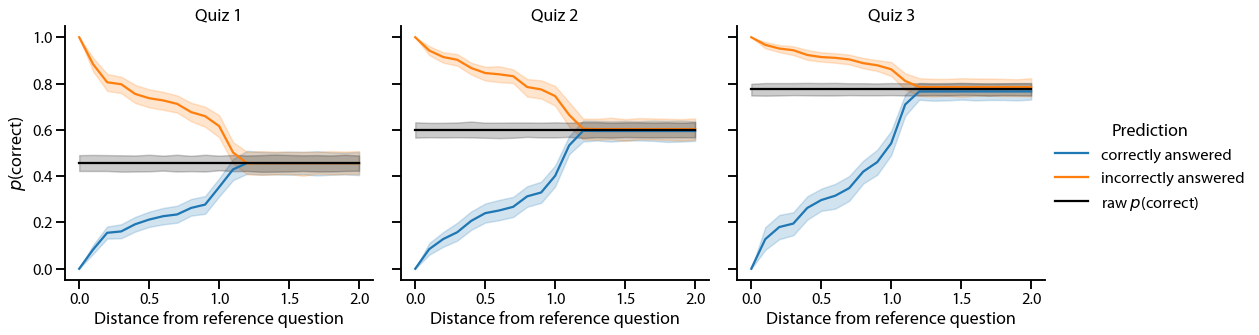

In [10]:
grouped_df = df.groupby(['quiz', 'participant', 'accuracy', 'max_dist'], as_index=False).mean()
data = grouped_df.rename(columns={
    'quiz': 'Quiz', 
    'max_dist': 'Distance from reference question', 
    'prop_correct': '$p$(correct)'
})


with sns.plotting_context('talk'):
    g = sns.relplot(data=data, x='Distance from reference question', col='Quiz')
    g.map_dataframe(sns.lineplot, 
                    x='Distance from reference question', 
                    y='$p$(correct)', 
                    hue='accuracy')
    g.map_dataframe(sns.lineplot, 
                    x='Distance from reference question', 
                    y='raw_prop_correct', 
                    color='k', 
                    label='raw')
    g.set_titles('{col_var} {col_name}')
    g.set_ylabels('$p$(correct)')
    legend_data = {
        'correctly answered': g._legend_data['0'],
        'incorrectly answered': g._legend_data['1'],
        'raw $p$(correct)': g._legend_data['raw']
    }
    g.add_legend(legend_data, title='Prediction')
#     for ax in g.axes.ravel():
#         (
#             incorrect_ribbon, 
#             correct_ribbon, 
#             pcorrect_ribbon
#         ) = ax.collections[1:4]
#         break
#         for obj in (incorrect_ribbon, correct_ribbon, pcorrect_ribbon):
#             assert len(obj.get_paths()) == 1

#     incorrect_error_ribbon, correct_error_ribbon, pcorrect_error_ribbon = 
#     g.axes[0, 0].collections[1].remove()
    plt.show()

In [12]:
# with sns.plotting_context('talk'):
#     g = sns.relplot(data=df.groupby(['quiz', 'participant', 'accuracy', 'max_dist'], 
#                                     as_index=False).mean(),
#                     x='max_dist',
#                     col='quiz')
#     g.map(sns.lineplot, 'max_dist', 'n_within_dist', 'accuracy')
# #     g.map(sns.lineplot, 'max_dist', 'raw_prop_correct', color='k', label='raw')
#     g.set_titles('{col_var} {col_name}')
#     g.set_xlabels('Distance from reference question')
#     g.set_ylabels('number of questions within radius')
#     legend_data = {
#         'correctly answered': g._legend_data['0'],
#         'incorrectly answered': g._legend_data['1'],
# #         'raw $p$(correct)': g._legend_data['raw']
#     }
#     g.add_legend(legend_data, title='Prediction')
#     plt.show()

In [40]:
sns.utils.ci(sns.algorithms.bootstrap(x, n_boot=1000, func=np.mean), which=95)

/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


ValueError: operands could not be broadcast together with shapes (3,) (50,) 

In [41]:
grouped_df.query('')

,quiz,participant,accuracy,max_dist,raw_prop_correct,prop_correct
0,1,P1,0,0.0,0.538462,0.000000
1,1,P1,0,0.1,0.538462,0.222222
2,1,P1,0,0.2,0.538462,0.222222
3,1,P1,0,0.3,0.538462,0.222222
4,1,P1,0,0.4,0.538462,0.388889
...,...,...,...,...,...,...
6190,3,P9,1,1.6,0.769231,0.769231
6191,3,P9,1,1.7,0.769231,0.769231
6192,3,P9,1,1.8,0.769231,0.769231
6193,3,P9,1,1.9,0.769231,0.769231


In [169]:
np.atleast_2d(np.array([1, 2, 3, 4]))

array([1, 2, 3, 4])

In [ ]:
def bootstrap_ci_plot(
    M, 
    ci=95, 
    n_boots=1000, 
    color='#1f77b4', 
    alpha=0.3, 
    return_bounds=False, 
    label=None, 
    ax=None,
    line_kwargs=None,
    ribbon_kwargs=None
):
    """
    Plots a timeseries of observations with error ribbons denoting the 
    bootstrap confidence interval at each timepoint.  Looks very similar 
    to `seaborn.lineplot`, but runs about 2-3 times as fast.
    
    Parameters
    ----------
    M : numpy.ndarray
        A (timepoints, observations) array of values for plotting
    ci : int, optional
        The size of the confidence interval as a percentage (default: 95).
    n_boots : int, optional
        The number of bootstraps to use for computing the confidence 
        interval. Full-size resamples of observations are constructed 
        (with replacement) for each timepoint independently.
    color : str or tuple of float, optional
        Any color specification accepted by Matplotlib.  See 
        https://matplotlib.org/3.1.1/tutorials/colors/colors.html for a 
        full list of options.  Unless otherwise specified in 
        `ribbon_kwargs`, this also sets the color of the CI ribbon.  
        Defaults to the first color in the currently set palette.
    alpha : float, optional
        Alpha value for the CI ribbon (default: 0.3).
    return_bounds : bool, optional
        If True (default: False), return arrays containing the lower and 
        upper bounds of the computed confidence interval for each 
        timepoint in addition to the axis object.
    label : str, optional
        Label assigned to the line if constructing a legend.
    ax : matplotlib.axes.Axes, optional
        The axes on which to draw the plot.  May be a 
        `matplotlib.axes.Axes` object or one of its various subclasses.  
        Defaults to the current Axes.
    line_kwargs : dict, optional
        Additional keyword arguments forwarded to 
        `matplotlib.axes.Axes.plot`.
    ribbon_kwargs : dict, optional
        Additional keyword argumets forwarded to 
        `matplotlib.axes.Axes.fill_between`.

    Returns
    -------
    returns : matplotlib.axes.Axes or list of objects
        Return value depends on the value passed to `return_bounds`. If 
        False (default), the Axes object alone is returned.  If True, a 
        3-tuple is returned, where the first item is the Axes object and 
        the second and third items are 1-D Numpy arrays respectively 
        containing the lower and upper bounds of the confidence interval 
        at each timepoint.

    """
    line_kwargs = {} if line_kwargs is None else line_kwargs
    ribbon_kwargs = {} if ribbon_kwargs is None else ribbon_kwargs
    if color is None:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    if 'color' not in ribbon_kwargs:
        ribbon_kwargs['color'] = color

    timepoints = np.arange(M.shape[0])
    obs_mean = M.mean(axis=1)
    
    # (n_tpts, n_obs, n_boots) column indices to subsample each row of M
    rand_ixs = np.random.randint(0, M.shape[1], size=(*M.shape, n_boots))
    # (n_tpts, n_boots) subsample means for each timepoint
    boot_means = np.take_along_axis(M[:, np.newaxis], rand_ixs, axis=2).mean(axis=1)
    ci_low = np.percentile(boot_means, (100 - ci) / 2, axis=1)
    ci_high = np.percentile(boot_means, (ci + 100) / 2, axis=1)
    
    if ax is None:
        ax = plt.gca()
    
    ax.fill_between(timepoints, ci_low, ci_high, alpha=alpha, **ribbon_kwargs)
    ax.plot(timepoints, obs_mean, color=color, label=label, **line_kwargs)
    if return_bounds:
        return ax, ci_low, ci_high
    else:
        return ax